In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as web
import time
from scipy import stats
%matplotlib inline

Risk-free rate is 10 Year US government bond yield:
https://www.bloomberg.com/markets/rates-bonds/government-bonds/us

In [7]:
# Import Stocks Data
def get_data(tickers, start, end, interval,OHLC='Adj Close'):
    df = pd.DataFrame()
    for t in tickers:
        df[t] = web.get_data_yahoo(t, start, end, interval=interval)[OHLC]
    df.dropna(inplace=True)
    
    return df

### Two returns calculation methods
# Calculate Simple Returns of the stocks
def simp_ret(stocks_price):
    simp_ret = (stocks_price/stocks_price.shift(1) - 1)[1:]
    
    return simp_ret

# Calculate Log Returns of the stocks
def log_ret(stocks_price):
    log_return = np.log(stocks_price/stocks_price.shift(1))[1:]
    
    return log_return

### Annualizing returns above
# Calculate annualized simple returns by compounding the geometric return
def annual_simpret(simp_return, frequency):
    # find Geometric mean of [monthly] simple returns
    grossret = simp_return + 1
    geomret = np.prod(grossret)**(1/len(grossret))
    # compound [monthly] Geometric mean to annualize
    annual_simpret = geomret**frequency - 1
    
    return annual_simpret

# Calculate annualized log returns by compounding the mean return
def annual_logret(log_return, frequency):
    # find mean of log returns & compound it to annualize
    annual_logret = log_return.mean()*frequency
    
    return annual_logret


### Calculate beta of stocks, 
# specify risk_free = e.g. monthly risk-free rate to find beta between excess returns of stock & mkt
# however, difference from including risk_free is negigible, using risk-free=0 is fine
# depends on specific returns frequency, e.g. monthly
def get_beta(stock_returns, risk_free=0):
    tickers = stock_returns.columns
    Beta_df = pd.DataFrame(columns = ['ticker','Beta'])
    stock_returns = stock_returns - risk_free

    for stock in range(len(tickers)):
        stock_mkt_cov = stock_returns.cov().loc['^GSPC',tickers[stock]]
        mkt_var = stock_returns['^GSPC'].var()
        Beta = stock_mkt_cov/mkt_var
        Beta_df = Beta_df.append({'ticker':tickers[stock],'Beta':Beta },ignore_index=True)
        
    return Beta_df

# depends on specific returns frequency, e.g. monthly
# risk-free, Mkt, actual stock returns must be annualized returns
def CAPM(beta_df, risk_free, Mkt_ret, actual_ret): # expected returns in annualized terms
    stocks = list(beta_df['ticker'])[1:]
    ER_df = pd.DataFrame(columns = ['ticker','CAPM ER'])
    
    for stock in stocks:
        beta = float(beta_df[beta_df['ticker']==stock]['Beta'])
        expected_return = risk_free + beta*(Mkt_ret - risk_free)
        actual_return = actual_ret[stock]
        return_gap = actual_return - expected_return
        ER_df = ER_df.append({'ticker':stock,
                              'Beta': beta,
                              'CAPM ER':expected_return, 
                              'Actual Return': actual_return,
                              'Return Gap': return_gap},
                             ignore_index=True)
        
    
    # if CAPM Expected Returns < actual returns, undervalued
    ER_df['Undervalued'] = ER_df['CAPM ER'] < ER_df['Actual Return']             
    return ER_df

In [8]:
# Top 25 S&P500 stocks as of 10 Oct 2022
tickers = ['AAPL','MSFT','AMZN','TSLA','GOOGL',
           'GOOG','BRK-B','UNH','JNJ','XOM',
           'JPM','META','V','PG','NVDA',
           'HD','CVX','LLY','MA','ABBV',
           'PFE','MRK','PEP','BAC','KO']

tickers.insert(0,'^GSPC')

## Pre-specifications
end = dt.datetime.now()
start = end - dt.timedelta(weeks=52*5+8) 
print('start date:', start)
print('end date:', end)
print('end - start:', (end-start)/365)
# 52weeks * 5 years ago, +4(add 1 month to get 60 weeks data)
# +4(1 month for first data point lost in calculating returns)

# 'd' = daily, 'w' = weekly, 'm' = monthly
interval = 'm'
frequency = {'d':252, 'w':52, 'm': 12} # frequency of compounding
# monthly frequency
frequency = frequency[interval]
print('Frequency:',frequency)

## risk-free rate settings
# source: https://www.bloomberg.com/markets/rates-bonds/government-bonds/us
# Long-term Risk-free rate, 10Year Treasury Bond Yield
risk_free = 0.0402 # 0.0402

# convert annual risk-free YTM to monthly rate
risk_free_mo = (1+risk_free)**(1/frequency)-1

print('Risk-free with frequency:',risk_free_mo, 
      'Compounded back to annual risk-free:',round((risk_free_mo+1)**12 -1, 4))

## download historical prices
stock_P = get_data(tickers, start, end, interval)[:-1]
stock_P.to_excel('stock_P.xlsx', sheet_name='sheet1', index=True)
stock_P.head()

start date: 2017-10-26 17:31:47.379115
end date: 2022-12-15 17:31:47.379115
end - start: 5 days, 3:21:12.328767
Frequency: 12
Risk-free with frequency: 0.003289816470036566 Compounded back to annual risk-free: 0.0402


,^GSPC,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,BRK-B,UNH,JNJ,...,HD,CVX,LLY,MA,ABBV,PFE,MRK,PEP,BAC,KO
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-01,2647.580078,40.706699,78.868057,58.837502,20.590000,51.808498,51.070499,193.009995,211.355972,121.332161,...,158.990219,94.675148,76.439217,146.451004,76.838577,28.419912,44.756683,100.014999,25.147053,38.722603
2017-12-01,2673.610107,40.230190,80.554283,58.473499,20.756666,52.669998,52.320000,198.220001,204.903595,122.416878,...,168.424362,100.540657,76.758362,147.317215,76.672089,28.647963,45.566467,103.647476,26.464476,39.133900
2018-01-01,2823.810059,39.802284,89.472321,72.544502,23.620667,59.111000,58.497002,214.380005,220.072037,121.076393,...,178.528229,100.669159,74.022827,164.486053,88.968491,29.296534,48.387745,103.975929,28.687780,40.592464
2018-02-01,2713.830078,42.343559,88.304596,75.622498,22.870667,55.195999,55.236500,207.199997,210.201385,113.795479,...,161.972839,89.883453,69.996780,171.334824,92.489227,28.719149,44.279888,94.840218,28.777428,36.865013
2018-03-01,2640.870117,40.048107,86.354042,72.366997,17.742001,51.856998,51.589500,199.479996,198.899445,112.998695,...,158.391632,92.497749,70.838188,170.749985,75.577179,28.330633,44.484055,94.338921,26.885832,37.044147


In [9]:
### Using Simple Returns: all returns in annual terms
# calculate returns
simpret = simp_ret(stock_P)

## annual Market Returns(Rm) setting
Mkt_ret_simp = annual_simpret(simpret['^GSPC'], frequency) 

# calculate beta based on monthly
beta_simp = get_beta(simpret, risk_free_mo)

# calculate actual annual stock returns
actual_simpret = annual_simpret(simpret, frequency)

# calculate CAPM Expected Returns of stocks & find undervalued stocks
capm_dfsimp = CAPM(beta_simp, risk_free, Mkt_ret_simp, actual_simpret)
buytickers = list(capm_dfsimp[capm_dfsimp['Undervalued'] == True]['ticker'])

print(f'{len(buytickers)} out of {len(tickers[1:])} stocks;',
      f'{round(100 * len(buytickers)/len(tickers[1:]),2)}% of stocks are undervalued. \nUndervalued stocks:', buytickers)

capm_dfsimp.sort_values(by=['Return Gap'], ascending=False)

21 out of 25 stocks; 84.0% of stocks are undervalued. 
Undervalued stocks: ['AAPL', 'MSFT', 'TSLA', 'GOOGL', 'GOOG', 'BRK-B', 'UNH', 'JNJ', 'XOM', 'V', 'PG', 'NVDA', 'HD', 'CVX', 'LLY', 'MA', 'ABBV', 'PFE', 'MRK', 'PEP', 'KO']


,ticker,CAPM ER,Actual Return,Beta,Return Gap,Undervalued
3,TSLA,0.126038,0.490895,1.945876,0.364857,True
17,LLY,0.055677,0.358993,0.350860,0.303316,True
0,AAPL,0.094011,0.280768,1.219845,0.186757,True
1,MSFT,0.081022,0.261820,0.925395,0.180798,True
14,NVDA,0.116788,0.283802,1.736184,0.167014,True
21,MRK,0.059005,0.195247,0.426284,0.136243,True
7,UNH,0.072905,0.201206,0.741396,0.128301,True
18,MA,0.089050,0.191923,1.107392,0.102873,True
19,ABBV,0.069874,0.162038,0.672694,0.092163,True
13,PG,0.058568,0.139948,0.416381,0.081380,True


In [10]:
### Using Log Returns: all returns in annual terms
# calculate returns 
logret = log_ret(stock_P)

## Market Returns(Rm) setting
Mkt_ret_log = annual_logret(logret['^GSPC'], frequency)

# calculate beta
beta_log = get_beta(logret, 0)

# calculate actual annual stock returns
actual_logpret = annual_logret(logret, frequency)

# calculate CAPM Expected Returns of stocks & find undervalued stocks
capm_dflog = CAPM(beta_log, risk_free, Mkt_ret_log,actual_logpret)

buytickers = list(capm_dflog[capm_dflog['Undervalued'] == True]['ticker'])

print(f'{len(buytickers)} out of {len(tickers[1:])} stocks;',
      f'{round(100 * len(buytickers)/len(tickers[1:]),2)}% of stocks are undervalued. \nUndervalued stocks:', buytickers)

capm_dflog.sort_values(by=['Return Gap'], ascending=False)

21 out of 25 stocks; 84.0% of stocks are undervalued. 
Undervalued stocks: ['AAPL', 'MSFT', 'TSLA', 'GOOGL', 'GOOG', 'BRK-B', 'UNH', 'JNJ', 'XOM', 'V', 'PG', 'NVDA', 'HD', 'CVX', 'LLY', 'MA', 'ABBV', 'PFE', 'MRK', 'PEP', 'KO']


,ticker,CAPM ER,Actual Return,Beta,Return Gap,Undervalued
3,TSLA,0.110521,0.399377,1.725823,0.288856,True
17,LLY,0.053938,0.306744,0.337165,0.252806,True
0,AAPL,0.088890,0.247460,1.194941,0.158570,True
1,MSFT,0.077419,0.232555,0.913423,0.155136,True
14,NVDA,0.112750,0.249826,1.780523,0.137076,True
21,MRK,0.056874,0.178353,0.409212,0.121479,True
7,UNH,0.068932,0.183326,0.705137,0.114394,True
18,MA,0.084819,0.175568,1.095043,0.090749,True
19,ABBV,0.066987,0.150175,0.657411,0.083188,True
13,PG,0.056969,0.130983,0.411557,0.074013,True


In [11]:
def LinReg(SP500returns, stock, risk_free):
    SP500_excessret = SP500returns - risk_free
    stock_excessret = stock - risk_free
    LR = stats.linregress(x = SP500_excessret, y = stock_excessret)
    beta,alpha,r_val,p_val,std_err = LR
    
    return LR

beta,alpha,r_val,p_val,std_err = LinReg(simpret['^GSPC'],simpret['AAPL'],risk_free_mo)
beta, r_val**2, p_val, alpha

(1.2198445325279836,
 0.5022172903273361,
 1.659979557442339e-10,
 0.015625366773362175)

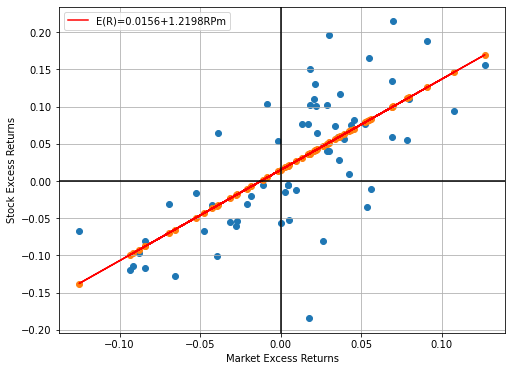

In [14]:
y_pred = alpha + risk_free_mo + beta*(simpret['^GSPC'] - risk_free_mo)

plt.figure(figsize=(8,6))
plt.scatter(x=simpret['^GSPC'],y=simpret['AAPL'])
plt.plot(simpret['^GSPC'], y_pred, '-r',label='E(R)={:.4f}+{:.4f}RPm'.format(alpha,beta))
plt.xlabel("Market Excess Returns")
plt.ylabel("Stock Excess Returns")

plt.legend()
plt.grid()
plt.axvline(0,c='black')
plt.axhline(0,c='black');
plt.scatter(x=simpret['^GSPC'],y=y_pred);

In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

SP500returns = simpret['^GSPC']
stock = simpret['AAPL']
risk_free = risk_free_mo

SP500_excessret = pd.DataFrame(SP500returns - risk_free)
stock_excessret = pd.DataFrame(stock - risk_free)
reg_df = pd.concat([stock_excessret,SP500_excessret],axis=1)

# To estimate the constant term beta_0, we need to add a column of 1’s to our dataset
reg_df['const'] = 1
reg_df.head()

# There's a constant term in the exogenous variables!!!
reg = sm.OLS(endog=reg_df['AAPL'], exog=reg_df[['^GSPC', 'const']])
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     59.53
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           1.66e-10
Time:                        17:33:35   Log-Likelihood:                 81.395
No. Observations:                  61   AIC:                            -158.8
Df Residuals:                      59   BIC:                            -154.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          1.2198      0.158      7.715      0.0